In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df_phone_dataset = pd.read_csv('phone_dataset.csv')
PHONE_COUNT = len(df_phone_dataset)

In [3]:
pd_1 = pd.read_csv('user_clicks.csv')
pd_2 = pd.read_csv('user_ratings.csv')
pd_3 = pd.read_csv('user_surveys.csv')

MIN_USER_ID = min(pd_1['user_id'].min(), pd_2['user_id'].min(), pd_3['user_id'].min())
MAX_USER_ID = max(pd_1['user_id'].max(), pd_2['user_id'].max(), pd_3['user_id'].max())
TOTAL_USER = MAX_USER_ID - MIN_USER_ID + 1

##Preprocess Dataset

### Preprocess Dataset User Clicks

In [4]:
df_user_clicks = pd.read_csv('user_clicks.csv')
df_user_clicks.head()

,user_id,phone_id,visit_time
0,1,15,2024-05-25 10:42:55
1,1,2,2024-05-25 10:42:55
2,1,3,2024-05-25 10:42:55
3,1,7,2024-05-25 10:42:55
4,1,14,2024-05-25 10:42:55


In [5]:
df_user_clicks = df_user_clicks.sort_values(by='visit_time', ascending=False)
df_user_clicks = df_user_clicks.drop_duplicates(subset=['user_id', 'phone_id'], keep='first')
df_user_clicks = df_user_clicks.groupby('user_id').head(20)
df_user_clicks = df_user_clicks.reset_index(drop=True)
df_user_clicks.head(5)

,user_id,phone_id,visit_time
0,1500,58,2024-05-25 10:47:38
1,1500,53,2024-05-25 10:47:38
2,1500,21,2024-05-25 10:47:38
3,1500,94,2024-05-25 10:47:38
4,1500,19,2024-05-25 10:47:38


In [6]:
user_counts = df_user_clicks['user_id'].value_counts()
users_with_count_gt_20 = user_counts[user_counts > 20]
len(users_with_count_gt_20.head())

0

In [7]:
# Identify missing user IDs
missing_user_ids = set(range(MIN_USER_ID, MAX_USER_ID + 1)) - set(df_user_clicks['user_id'])

# Create a DataFrame with missing user IDs and clicks initialized to 0
missing_data = pd.DataFrame({'user_id': list(missing_user_ids), 'phone_id': -1, 'visit_time': '2024-01-01 00:00:00'})

# Append the missing data to the original DataFrame
df_user_clicks_complete = pd.concat([df_user_clicks, missing_data], ignore_index=True)

# Sort by user_id to maintain order
df_user_clicks_complete = df_user_clicks_complete.sort_values(by='user_id').reset_index(drop=True)

In [8]:
train_clicks = df_user_clicks_complete[['user_id', 'phone_id']].pivot_table(index='phone_id', columns='user_id', aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)
train_clicks = train_clicks[1:]
train_clicks.head(96)


user_id,1,2,3,4,5,6,7,8,9,10,...,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507
phone_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


###Preprocess Dataset User Ratings

In [193]:
df_user_ratings = pd.read_csv("user_ratings.csv")
df_user_ratings.head()

,user_id,phone_id,rating
0,1,15,4.0
1,1,2,5.0
2,1,3,5.0
3,1,7,5.0
4,1,14,4.0


In [194]:
df_user_ratings.drop_duplicates(inplace=True)
df_user_ratings.duplicated().sum()

0

In [195]:
df_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10672 entries, 0 to 10671
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   10672 non-null  int64  
 1   phone_id  10672 non-null  int64  
 2   rating    10439 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 250.3 KB


In [196]:
# Identify missing user IDs
missing_user_ids = set(range(MIN_USER_ID, MAX_USER_ID + 1)) - set(df_user_ratings['user_id'])

# Create a DataFrame with missing user IDs and clicks initialized to 0
missing_data = pd.DataFrame({'user_id': list(missing_user_ids), 'phone_id': 1, 'rating': 0})
missing_data['user_id'] = missing_data['user_id'].astype(int)
# Append the missing data to the original DataFrame
df_user_ratings_complete = pd.concat([df_user_ratings, missing_data], ignore_index=True)

# Sort by user_id to maintain order
df_user_ratings_complete = df_user_ratings_complete.sort_values(by='user_id').reset_index(drop=True)

In [197]:
train_ratings = df_user_ratings_complete.pivot(index='phone_id', columns='user_id', values='rating').fillna(0)
train_ratings = train_ratings.astype(int)
train_ratings.head(PHONE_COUNT)

user_id,1,2,3,4,5,6,7,8,9,10,...,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507
phone_id,,,,,,,,,,,,,,,,,,,,,
1,5,5,5,0,5,5,0,0,4,0,...,0,0,0,3,3,3,3,5,0,0
2,5,0,0,5,0,4,4,0,0,5,...,0,0,0,3,3,3,3,5,0,5
3,5,5,0,4,0,5,0,0,4,0,...,0,0,0,3,3,3,3,4,0,3
4,5,0,0,0,0,4,4,0,0,0,...,0,0,0,3,4,3,3,5,0,5
5,0,5,0,5,4,0,4,0,5,4,...,0,0,0,4,3,3,3,5,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,3,3,3,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,5,5,4,3,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,5,5,4,5,0,0


### Preprocess Dataset Surveys

In [198]:
df_user_surveys = pd.read_csv('user_surveys.csv')
df_user_surveys.head()

,user_id,q1,q2,q3,q4,q5,q6,q7,q8
0,501,3,5,3,1,3,1,True,6
1,502,2,4,2,5,2,1,True,2
2,503,5,4,4,5,4,5,True,8
3,504,5,4,3,2,5,2,True,2
4,505,5,1,2,1,5,5,True,5


In [199]:
df_user_surveys['q7'] = df_user_surveys['q7'].astype(int)

In [200]:
# Identify missing user IDs
missing_user_ids = set(range(MIN_USER_ID, MAX_USER_ID + 1)) - set(df_user_surveys['user_id'])

# Create a DataFrame with missing user IDs and clicks initialized to 0
missing_data = pd.DataFrame({'user_id': list(missing_user_ids), 'q1': 0, 'q2': 0, 'q3': 0, 'q4': 0, 'q5': 0, 'q6': 0, 'q7': 0, 'q8': -1})
missing_data['user_id'] = missing_data['user_id'].astype(int)
# Append the missing data to the original DataFrame
df_user_surveys_complete = pd.concat([df_user_surveys, missing_data], ignore_index=True)

# Sort by user_id to maintain order
df_user_surveys_complete = df_user_surveys_complete.sort_values(by='user_id').reset_index(drop=True)

In [201]:
train_surveys =  df_user_surveys_complete.set_index('user_id').T
train_surveys.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507
q1,0,0,0,0,0,0,0,0,0,0,...,2,3,1,4,3,5,5,5,5,5
q2,0,0,0,0,0,0,0,0,0,0,...,2,4,4,5,4,4,3,3,3,5
q3,0,0,0,0,0,0,0,0,0,0,...,3,2,2,5,5,5,5,5,5,5
q4,0,0,0,0,0,0,0,0,0,0,...,3,4,5,4,3,3,5,5,5,3
q5,0,0,0,0,0,0,0,0,0,0,...,5,4,5,5,4,4,5,5,5,5
q6,0,0,0,0,0,0,0,0,0,0,...,2,5,3,5,3,5,5,5,5,3
q7,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
q8,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,0,8,3,4,8,3,8,-1,3


##Collaborative filtering learning algorithm

### Collaborative filtering cost (eksperimental)

In [202]:
input_1 = tf.convert_to_tensor(train_ratings.values)
input_2 = tf.convert_to_tensor(train_clicks.values)
input_2 = tf.cast(input_2, tf.float32)
input_3 = tf.convert_to_tensor(train_surveys.values)

In [23]:
def cofi_cost_func(X, W, b, Y, R, lambda_):
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [20]:
# def collaborative_model():
#   input_1 = tf.keras.layers.Input(shape=[PHONE_COUNT, TOTAL_USER])
#   input_2 = tf.keras.layers.Input(shape=[PHONE_COUNT, TOTAL_USER])
#   input_3 = tf.keras.layers.Input(shape=[8, TOTAL_USER])

#   input_1 = tf.keras.layers.Flatten()(input_1)
#   input_2 = tf.keras.layers.Flatten()(input_2)
#   input_3 = tf.keras.layers.Flatten()(input_3)

#   concat_1 = tf.keras.layers.concatenate([input_1, input_2])
#   x_1 = tf.keras.layers.Dense(units=128, activation='relu')(concat_1)

#   x_2 = tf.keras.layers.Dense(units=128, activation='relu')(input_3)

#   concat_2 = tf.keras.layers.concatenate([x_1, x_2])
#   output = tf.keras.layers.Dense(units=1, activation='sigmoid')(concat_2)

#   return tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])



In [21]:
def collaborative_model():
  input_1 = tf.keras.layers.Input(shape=[PHONE_COUNT, TOTAL_USER])
  input_2 = tf.keras.layers.Input(shape=[PHONE_COUNT, TOTAL_USER])


  input_3 = tf.keras.layers.Input(shape=[8, TOTAL_USER])

  input_1 = tf.keras.layers.Flatten()(input_1)
  input_2 = tf.keras.layers.Flatten()(input_2)
  input_3 = tf.keras.layers.Flatten()(input_3)

  concat = tf.keras.layers.concatenate([input_1, input_2, input_3])
  x = tf.keras.layers.Dense(units=128, activation='relu')(concat)

  output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

  return tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])


In [22]:
model = collaborative_model()
tf.keras.utils.plot_model(model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Collaborative Filtering for User Rating

In [23]:
R_train_ratings = train_ratings.applymap(lambda x: 1 if x != 0 else 0)
R_train_ratings.head(PHONE_COUNT)

C:\Users\ROG STRIX\AppData\Local\Temp\ipykernel_39668\1514983918.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  R_train_ratings = train_ratings.applymap(lambda x: 1 if x != 0 else 0)


user_id,1,2,3,4,5,6,7,8,9,10,...,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507
phone_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,0,1,1,0,0,1,0,...,0,0,0,1,1,1,1,1,0,0
2,1,0,0,1,0,1,1,0,0,1,...,0,0,0,1,1,1,1,1,0,1
3,1,1,0,1,0,1,0,0,1,0,...,0,0,0,1,1,1,1,1,0,1
4,1,0,0,0,0,1,1,0,0,0,...,0,0,0,1,1,1,1,1,0,1
5,0,1,0,1,1,0,1,0,1,1,...,0,0,0,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0


In [24]:
def cost_func_user_ratings(X, W, b, Y, R, lambda_):
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [25]:
class CollaborativeFilteringModel:
    def __init__(self, num_users, num_items, num_features, lambda_=0.1, learning_rate=0.01):
        self.num_users = num_users
        self.num_items = num_items
        self.num_features = num_features
        self.lambda_ = lambda_
        self.learning_rate = learning_rate

        # Initialize parameters
        self.X = tf.Variable(tf.random.normal([num_items, num_features]), dtype=tf.float32)
        self.W = tf.Variable(tf.random.normal([num_users, num_features]), dtype=tf.float32)
        self.b = tf.Variable(tf.zeros([num_items, num_users]), dtype=tf.float32)

    def cost_func_user_ratings(self, X, W, b, Y, R):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(j**2) + (self.lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
        return J

    def train(self, Y, R, epochs=1000):
        optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                cost = self.cost_func_user_ratings(self.X, self.W, self.b, Y, R)

            grads = tape.gradient(cost, [self.X, self.W, self.b])
            optimizer.apply_gradients(zip(grads, [self.X, self.W, self.b]))

            if (epoch+1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Cost: {cost.numpy()}")

    def predict(self):
        return tf.linalg.matmul(self.X, tf.transpose(self.W)) + self.b

In [26]:
model = CollaborativeFilteringModel(num_users = TOTAL_USER, num_items = PHONE_COUNT, num_features = 100)

model.train(Y = train_ratings, R = R_train_ratings, epochs=2000)

Epoch 100/2000, Cost: 7547.83251953125
Epoch 200/2000, Cost: 6940.7177734375
Epoch 300/2000, Cost: 6342.85107421875
Epoch 400/2000, Cost: 5760.556640625
Epoch 500/2000, Cost: 5213.9189453125
Epoch 600/2000, Cost: 4709.837890625
Epoch 700/2000, Cost: 4249.34716796875
Epoch 800/2000, Cost: 3830.875
Epoch 900/2000, Cost: 3451.759521484375
Epoch 1000/2000, Cost: 3108.968017578125
Epoch 1100/2000, Cost: 2799.433837890625
Epoch 1200/2000, Cost: 2520.2109375
Epoch 1300/2000, Cost: 2268.541748046875
Epoch 1400/2000, Cost: 2041.8782958984375
Epoch 1500/2000, Cost: 1837.8837890625
Epoch 1600/2000, Cost: 1654.425537109375
Epoch 1700/2000, Cost: 1489.560302734375
Epoch 1800/2000, Cost: 1341.521728515625
Epoch 1900/2000, Cost: 1208.703857421875
Epoch 2000/2000, Cost: 1089.6473388671875


In [27]:
# Collaborative Filtering Model
class CollaborativeFilteringModels(tf.Module):
    def __init__(self, num_users, num_items, num_features, lambda_):
        # Initialize model parameters
        self.num_users = num_users
        self.num_items = num_items
        self.num_features = num_features
        self.lambda_ = lambda_

        # Initialize user and item feature matrices with random values
        self.X = tf.Variable(tf.random.normal([num_items, num_features]), name='X')
        self.W = tf.Variable(tf.random.normal([num_users, num_features]), name='W')

        # Initialize bias terms
        self.b = tf.Variable(tf.random.normal([num_items, num_users]), name='b')

    def __call__(self, Y, R):
        return cost_func_user_ratings(self.X, self.W, self.b, Y, R, self.lambda_)

# Training function
def train_model(model, Y, R, learning_rate, num_epochs):
    optimizer = tf.optimizers.Adam(learning_rate)

    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            cost = model(Y, R)

        # Compute gradients
        gradients = tape.gradient(cost, [model.X, model.W, model.b])

        # Apply gradients to optimize the parameters
        optimizer.apply_gradients(zip(gradients, [model.X, model.W, model.b]))

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch + 1}, Cost: {cost.numpy()}')

In [28]:
model = CollaborativeFilteringModels(num_users = TOTAL_USER, num_items = PHONE_COUNT, num_features = 100, lambda_ = 0.1)

train_model(model, Y, R, learning_rate, num_epochs)

NameError: name 'Y' is not defined

In [ ]:
def collaborative_filtering_model(num_users, num_items, num_features, lambda_, learning_rate=0.001, num_epochs=1000):
    # Initialize the variables
    X = tf.Variable(tf.random.normal([num_items, num_features], stddev=0.35), name='X')
    W = tf.Variable(tf.random.normal([num_users, num_features], stddev=0.35), name='W')
    b = tf.Variable(tf.random.normal([num_items, num_users], stddev=0.35), name='b')

    # Placeholder for the true ratings and the R matrix
    Y = tf.placeholder(tf.float32, shape=[num_items, num_users], name='Y')
    R = tf.placeholder(tf.float32, shape=[num_items, num_users], name='R')

    # Cost function
    def cost_func_user_ratings(X, W, b, Y, R, lambda_):
        j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y) * R
        J = 0.5 * tf.reduce_sum(tf.square(j)) + (lambda_/2) * (tf.reduce_sum(tf.square(X)) + tf.reduce_sum(tf.square(W)))
        return J

    # Define the cost function
    cost = cost_func_user_ratings(X, W, b, Y, R, lambda_)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initialize all variables
    init = tf.global_variables_initializer()

    # Function to train the model
    def train_model(Y_train, R_train, num_epochs=num_epochs):
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(num_epochs):
                _, current_cost = sess.run([optimizer, cost], feed_dict={Y: Y_train, R: R_train})
                if epoch % 100 == 0:
                    print(f"Epoch {epoch}, Cost: {current_cost}")

            # Get the trained values of X, W, and b
            trained_X = sess.run(X)
            trained_W = sess.run(W)
            trained_b = sess.run(b)

        return trained_X, trained_W, trained_b

In [ ]:
model = collaborative_filtering_model(TOTAL_USER, PHONE_COUNT, 100, 1, learning_rate=0.001, num_epochs=1000)
tf.keras.utils.plot_model(model)

In [ ]:
def collaborative_model_ratings(num_features):
    W = tf.keras.layers.Embedding(input_dim=TOTAL_USER, output_dim=num_features, embeddings_initializer='random_normal', name='W')
    X = tf.keras.layers.Embedding(input_dim=PHONE_COUNT, output_dim=num_features, embeddings_initializer='random_normal', name='X')
    b = tf.keras.layers.Embedding(input_dim=TOTAL_USER, output_dim=1, embeddings_initializer='random_normal', name='b')

    user_input = tf.keras.Input(shape=(TOTAL_USER,), dtype=tf.int32, name='user_input')
    phone_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='phone_input')

    user_embedding = W(user_input)
    phone_embedding = X(phone_input)
    user_bias = b(user_input)

    dot_product = tf.keras.layers.Dot(axes=-1)([user_embedding, phone_embedding])
    output = tf.keras.layers.Add()([dot_product, user_bias])
    output = tf.keras.layers.Flatten()(output)

    model = tf.keras.Model(inputs=[user_input, phone_input], outputs=output, name='collaborative_model_ratings')

    return model

In [ ]:
model = collaborative_model_ratings(26)
tf.keras.utils.plot_model(model)

### Collaborative  Filtering for User Click

In [154]:
def cost_func_user_clicks(X, W, b, Y, lambda_):
    # j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)
    b = tf.reshape(b, (TOTAL_USER))
    j = (tf.linalg.matmul(X, tf.transpose(W)))
    j = j + b - Y
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [155]:
def collaborative_model_clicks(num_features):
    W = tf.keras.layers.Embedding(input_dim=TOTAL_USER, output_dim=num_features, embeddings_initializer='random_normal', name='W')
    X = tf.keras.layers.Embedding(input_dim=PHONE_COUNT, output_dim=num_features, embeddings_initializer='random_normal', name='X')
    b = tf.keras.layers.Embedding(input_dim=TOTAL_USER, output_dim=1, embeddings_initializer='random_normal', name='b')

    user_input = tf.keras.Input(shape=(TOTAL_USER,), dtype=tf.int32, name='user_input')
    phone_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='phone_input')

    user_embedding = W(user_input)
    phone_embedding = X(phone_input)
    user_bias = b(user_input)

    dot_product = tf.keras.layers.Dot(axes=-1)([user_embedding, phone_embedding])
    output = tf.keras.layers.Add()([dot_product, user_bias])
    output = tf.keras.layers.Flatten()(output)

    model = tf.keras.Model(inputs=[user_input, phone_input], outputs=output, name='collaborative_model_clicks')
    return model

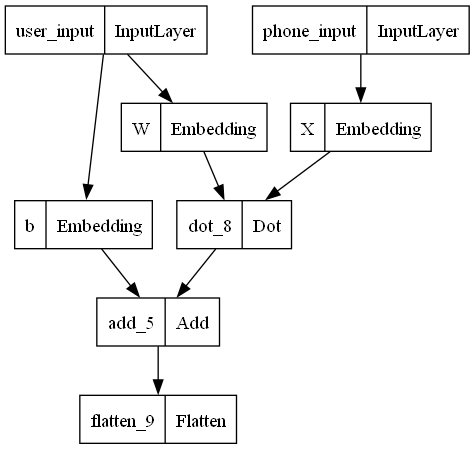

In [156]:
model = collaborative_model_clicks(100)
tf.keras.utils.plot_model(model)
# model.summary()

In [158]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


iterations = 250
lambda_ = 1

# Convert model layers to variables for custom training
W_var = model.get_layer('W').embeddings
X_var = model.get_layer('X').embeddings
b_var = model.get_layer('b').embeddings

for iter in range(iterations):
    with tf.GradientTape() as tape:
        cost_value = cost_func_user_clicks(X_var, W_var, b_var, input_2, lambda_)

    grads = tape.gradient(cost_value, [W_var, X_var, b_var])
    optimizer.apply_gradients(zip(grads, [W_var, X_var, b_var]))

    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value.numpy():0.4f}")

Training loss at iteration 0: 14473.1572
Training loss at iteration 20: 6220.5972
Training loss at iteration 40: 2918.3303
Training loss at iteration 60: 1827.0730
Training loss at iteration 80: 1510.1418
Training loss at iteration 100: 1428.1083
Training loss at iteration 120: 1400.5841
Training loss at iteration 140: 1389.3308
Training loss at iteration 160: 1383.6011
Training loss at iteration 180: 1380.1638
Training loss at iteration 200: 1377.9044
Training loss at iteration 220: 1376.3915
Training loss at iteration 240: 1375.3838


In [159]:
W_var = model.get_layer('W').embeddings
X_var = model.get_layer('X').embeddings
b_var = model.get_layer('b').embeddings

p = np.matmul(X_var.numpy(), np.transpose(W_var.numpy())) + np.reshape(b_var.numpy(), (TOTAL_USER))

user_id = 155

probability = p[:, user_id]


In [160]:
index = 1
for i in range(PHONE_COUNT):
    if probability[i] > 0.5:
        name =  df_phone_dataset.iloc[i]['name']
        id =  df_phone_dataset.iloc[i]['id']
        print(f'{index}. Probability clicking {probability[i]:0.2f} for phone { name } id { id }')
        index += 1

1. Probability clicking 0.95 for phone Oppo Reno 11 Pro id 1
2. Probability clicking 0.95 for phone Infinix Hot 40 Pro id 26
3. Probability clicking 0.94 for phone Infinix Zero 30 5G id 27
4. Probability clicking 0.95 for phone Samsung Galaxy A15 id 29
5. Probability clicking 0.95 for phone Samsung Galaxy A25 id 30
6. Probability clicking 0.94 for phone Samsung Galaxy Z Fold5 id 34
7. Probability clicking 0.95 for phone Samsung Galaxy Z Flip5 id 35
8. Probability clicking 0.94 for phone Samsung Galaxy M34 id 36
9. Probability clicking 0.95 for phone Vivo Y17s id 49
10. Probability clicking 0.95 for phone Huawei P60 Pro id 56
11. Probability clicking 0.95 for phone Huawei Nova Y72 id 58
12. Probability clicking 0.95 for phone iPhone 14 id 64
13. Probability clicking 0.95 for phone iPhone 14 Pro id 66
14. Probability clicking 0.95 for phone iPhone 15 Pro Max id 71
15. Probability clicking 0.95 for phone Realme C53 id 77
16. Probability clicking 0.95 for phone Realme 12 5G id 81
17. Proba

In [161]:
df_result = pd.DataFrame()
df_result['probability'] = probability
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
sorted_df_result = sorted_df_result[sorted_df_result['probability'] <= 0.5]
sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()

In [162]:
datas = sorted_df_result.to_numpy()
for i in range(10):
    prob = datas[i][0]
    print(f'{i + 1}. Probability clicking {prob:0.2f} for phone { (datas[i][1]) }')

1. Probability clicking 1.00 for phone Samsung Galaxy M54
2. Probability clicking 0.94 for phone Infinix GT 20 Pro
3. Probability clicking 0.90 for phone Samsung Galaxy S24 Ultra
4. Probability clicking 0.88 for phone Huawei Pura 70 Pro
5. Probability clicking 0.85 for phone iPhone 15
6. Probability clicking 0.82 for phone Vivo T3x
7. Probability clicking 0.80 for phone Infinix Note 40 Pro
8. Probability clicking 0.79 for phone Samsung Galaxy A55
9. Probability clicking 0.78 for phone Asus Zenfone 10
10. Probability clicking 0.78 for phone Huawei Mate X3


### Testing Functional

In [10]:
def collaborative_model_clicks_functional(num_features):
    # X = tf.keras.layers.Embedding(input_dim=PHONE_COUNT, output_dim=num_features, embeddings_initializer='random_normal', name='X')
    X = tf.keras.layers.Dense(units=num_features, activation=None, kernel_initializer='random_normal', name='X')
    phone_input = tf.keras.Input(shape=(PHONE_COUNT,), dtype=tf.int32, name='phone_input')

 
    phone_embedding = X(phone_input)

    output = tf.keras.layers.Dense(PHONE_COUNT, activation='sigmoid')(phone_embedding)

    # Define the model
    model = tf.keras.Model(inputs=phone_input, outputs=output, name='collaborative_model_clicks')


    return model

In [89]:
model = collaborative_model_clicks_functional(100)
model.compile(optimizer='adam', loss='mse')

phone_data = train_clicks.to_numpy().T
val_data = val_clicks.to_numpy().T

print(phone_data.shape)
model.fit(phone_data, train_clicks.to_numpy().T, epochs=1000, batch_size=32)

(1507, 96)
Epoch 1/1000
48/48 [==============================] - 0s 853us/step - loss: 0.1840
Epoch 2/1000
48/48 [==============================] - 0s 767us/step - loss: 0.1422
Epoch 3/1000
48/48 [==============================] - 0s 791us/step - loss: 0.1291
Epoch 4/1000
48/48 [==============================] - 0s 766us/step - loss: 0.1148
Epoch 5/1000
48/48 [==============================] - 0s 778us/step - loss: 0.1004
Epoch 6/1000
48/48 [==============================] - 0s 766us/step - loss: 0.0862
Epoch 7/1000
48/48 [==============================] - 0s 794us/step - loss: 0.0731
Epoch 8/1000
48/48 [==============================] - 0s 749us/step - loss: 0.0614
Epoch 9/1000
48/48 [==============================] - 0s 766us/step - loss: 0.0513
Epoch 10/1000
48/48 [==============================] - 0s 787us/step - loss: 0.0427
Epoch 11/1000
48/48 [==============================] - 0s 810us/step - loss: 0.0356
Epoch 12/1000
48/48 [==============================] - 0s 766us/step - los

In [103]:
data = [0 for i in range(96)]
for i in range(52, 58):
    data[i] = 1
# for i in range(0, 6):
#     data[i] = 1


tes = np.array(data)
tes = np.reshape(tes, (1,PHONE_COUNT))
result = model.predict(tes)

1/1 [==============================] - 0s 15ms/step


In [104]:
print(result)

[[1.50181411e-04 8.36646141e-05 1.38179894e-04 1.64047131e-04
  2.12346466e-04 2.07178862e-04 2.55613500e-04 1.92830368e-04
  2.08675468e-04 2.23822761e-04 3.04544228e-04 1.11448222e-04
  1.51569984e-04 1.31440625e-04 1.26011364e-04 1.99253613e-04
  1.31177309e-04 8.26737232e-05 4.06985724e-04 1.69450650e-04
  1.25298568e-04 2.30456397e-04 1.97331727e-04 2.12345258e-04
  1.78914313e-04 2.27233933e-04 2.18072120e-04 2.23911324e-04
  2.15846492e-04 1.42526958e-04 9.75322037e-05 1.54418289e-04
  2.59955123e-04 1.97970599e-04 1.06424908e-04 1.33048918e-04
  2.28375342e-04 1.69202816e-04 1.69580453e-04 1.96613910e-04
  1.24127677e-04 2.72897450e-04 1.01591475e-04 1.85154058e-04
  1.19256358e-04 2.89799209e-04 1.05376006e-04 1.89187427e-04
  1.56336595e-04 2.15953114e-04 3.99529294e-04 1.86528065e-04
  9.99960124e-01 9.99969423e-01 9.99960780e-01 9.99960303e-01
  9.99974310e-01 9.99966323e-01 2.56122672e-04 3.30494106e-04
  2.18244968e-04 1.58670417e-04 2.63903785e-04 1.31612964e-04
  7.6599

In [105]:
index = 1
probability = result[check_user]
data_user_clicked = data
for i in range(PHONE_COUNT):
    if data_user_clicked[i] != 1:
        name =  df_phone_dataset.iloc[i]['name']
        id =  df_phone_dataset.iloc[i]['id']
        print(f'{index}. Probability clicking {probability[i]:0.5f} for phone { name } id { id }')
        index += 1
    else:
        probability[i] = 0

1. Probability clicking 0.00015 for phone Oppo Reno 11 Pro id 1
2. Probability clicking 0.00008 for phone Oppo Reno 11 id 2
3. Probability clicking 0.00014 for phone Oppo Reno 11F id 3
4. Probability clicking 0.00016 for phone Oppo Reno 10 id 4
5. Probability clicking 0.00021 for phone Oppo Reno 10 Pro id 5
6. Probability clicking 0.00021 for phone Oppo Reno 10 Pro+ id 6
7. Probability clicking 0.00026 for phone Oppo Find X7 Ultra id 7
8. Probability clicking 0.00019 for phone Oppo Find X7 id 8
9. Probability clicking 0.00021 for phone Oppo A98 5G id 9
10. Probability clicking 0.00022 for phone Oppo A60 id 10
11. Probability clicking 0.00030 for phone Oppo Find N3 id 11
12. Probability clicking 0.00011 for phone Oppo A79 id 12
13. Probability clicking 0.00015 for phone Oppo A18 id 13
14. Probability clicking 0.00013 for phone Oppo A38 id 14
15. Probability clicking 0.00013 for phone Oppo Pad Neo id 15
16. Probability clicking 0.00020 for phone Asus Zenfone 11 Ultra id 16
17. Probabilit

In [106]:
df_result = pd.DataFrame()
df_result['probability'] = np.reshape(result[check_user], 96).astype(float)
df_result['name'] = df_phone_dataset['name']
sorted_df_result = df_result.sort_values(by='probability', ascending=False)
# sorted_df_result = sorted_df_result[sorted_df_result['probability'] <= 0.7]
sorted_df_result['probability'] = sorted_df_result['probability'] / sorted_df_result['probability'].max()
datas = sorted_df_result.to_numpy()
for i in range(10):
    prob = datas[i][0]
    print(f'{i + 1}. Recommending clicking {prob:0.2f} for phone { (datas[i][1]) }')

1. Recommending clicking 1.00 for phone Asus ROG Phone 8
2. Recommending clicking 0.98 for phone Huawei Pura 70 Ultra
3. Recommending clicking 0.82 for phone Realme Note 50
4. Recommending clicking 0.81 for phone Huawei Nova 11
5. Recommending clicking 0.75 for phone Oppo Find N3
6. Recommending clicking 0.71 for phone Vivo T3x
7. Recommending clicking 0.71 for phone Realme 12+ 5G
8. Recommending clicking 0.67 for phone Vivo V30
9. Recommending clicking 0.65 for phone iPhone SE (3rd gen)
10. Recommending clicking 0.64 for phone Samsung Galaxy S24


In [71]:
 model.save("model_C5.h5")

C:\Users\ROG STRIX\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
